In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm

In [2]:
# dir_dataset = "datasety/"
# train_x = np.load(dir_dataset + 'train_x.npy')
# train_y = np.load(dir_dataset + 'train_y.npy')

# test_x = np.load(dir_dataset + 'test_x.npy')
# test_y = np.load(dir_dataset + 'test_y.npy')

In [3]:
# from random import shuffle
# ind = [i for i in range(len(train_y))]
# shuffle(ind)
# train_x = train_x[ind]
# train_y = train_y[ind]

In [4]:
# print(train_x.shape)
# print(train_y.shape)

In [5]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
import torch.nn.functional as F

In [6]:
class NCarsImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images = np.load(img_dir_file + '_x.npy')
        self.labels = np.load(img_dir_file + '_y.npy')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        # print(np.max(cv2.resize(image.T, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)),image.T.shape, )
        label_temp = np.zeros((2,))
        label_temp[label] = 1
        return torch.tensor(cv2.resize(image.T, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)).T, torch.tensor(label_temp)

In [7]:
from torch.utils.data import DataLoader
training_data = NCarsImageDataset("./Datasety/train_EST")
test_data = NCarsImageDataset("./Datasety/test_EST")



In [8]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [9]:
from torch import nn

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.hardtanh(out, inplace=False, min_val=-1.0, max_val=1.0)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_channels = 5):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.1)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.hardtanh(x)
        # x = self.dropout(x)
        x = self.fc2(x)
        return F.hardtanh(x)
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
        best_accuracy = 0.0
        total_step = len(train_loader)
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs

            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))


            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet_nCars_Hardtanh_ReLUmaxpool_EST__FC2.pt")

                print('Accuracy of the network: {} Loss: {}%'.format( 100 * correct / total, val_loss/len(valid_loader)))

In [11]:
# creating the model

model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], in_channels = 12).to("cuda")


In [12]:
img, label = next(iter(train_dataloader))

C:\Users\nikos\AppData\Local\Temp\ipykernel_21996\54537038.py:21: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3575.)
  return torch.tensor(cv2.resize(image.T, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)).T, torch.tensor(label_temp)


In [13]:
print(img.shape)

torch.Size([32, 12, 224, 224])


tensor([1., 0.], dtype=torch.float64)


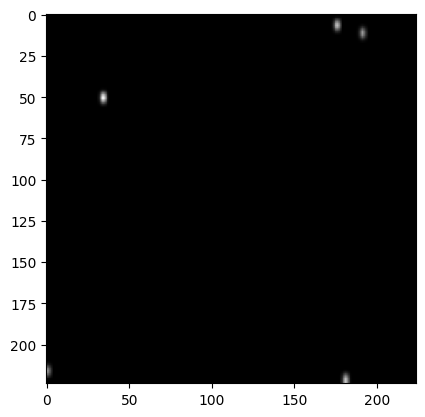

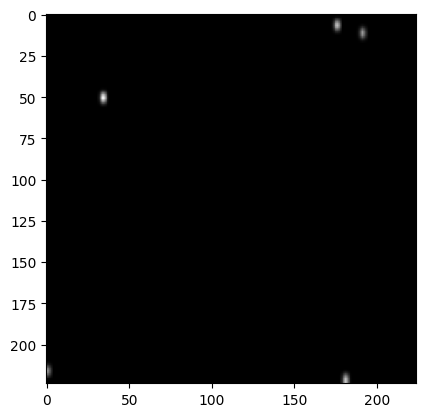

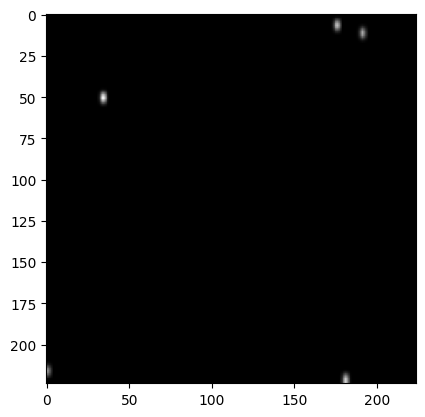

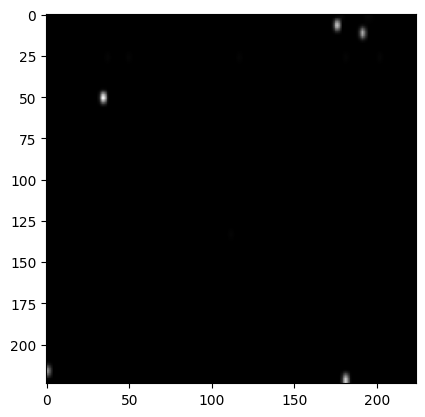

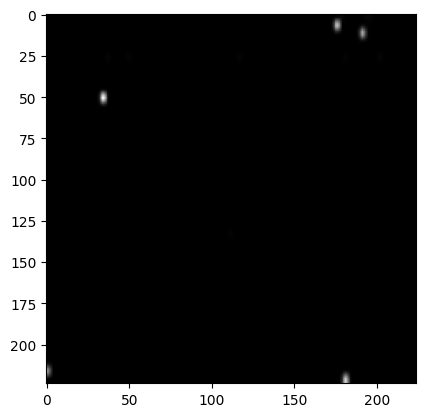

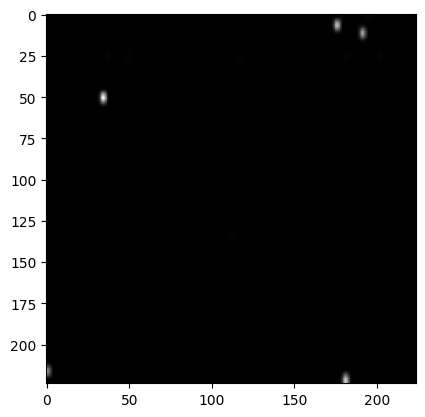

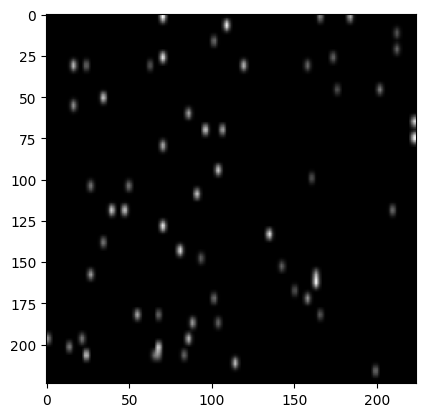

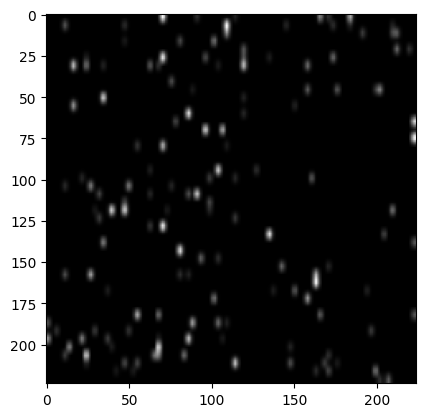

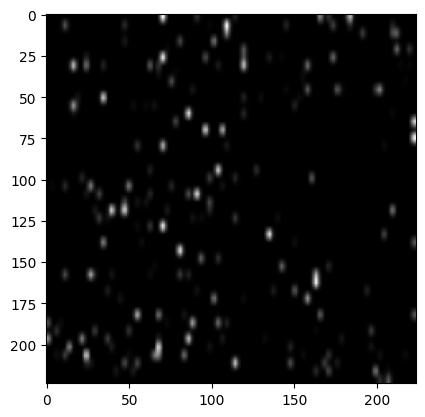

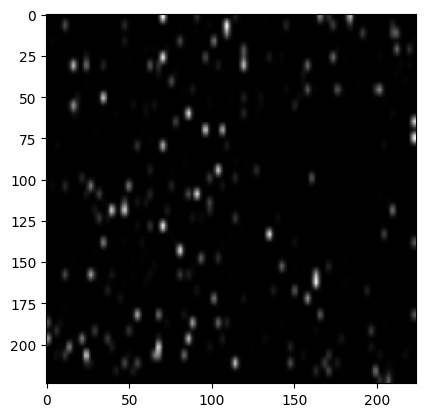

tensor(1.)


In [14]:
for j in range(1):
    print(label[j])
    for i in range(10):
        plt.imshow(img[j,i,:,:])
        plt.gray()
        
        plt.show()
print(torch.max(img))

In [ ]:
model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=10) #, learning_rate=5e-4

100%|██████████| 482/482 [02:21<00:00,  3.41it/s]


Epoch [1/10], Step [482/482], Loss: 0.6559, Accuracy: 0.5818
Accuracy of the network: 65.67909840827234 Loss: 0.629138873633842%


100%|██████████| 482/482 [02:25<00:00,  3.32it/s]


Epoch [2/10], Step [482/482], Loss: 0.5165, Accuracy: 0.7590
Accuracy of the network: 66.85256186824678 Loss: 0.6399947499032357%


100%|██████████| 482/482 [02:23<00:00,  3.37it/s]


Epoch [3/10], Step [482/482], Loss: 0.4958, Accuracy: 0.7765
Accuracy of the network: 70.82607180202162 Loss: 0.6068608568060354%


100%|██████████| 482/482 [02:25<00:00,  3.31it/s]


Epoch [4/10], Step [482/482], Loss: 0.4612, Accuracy: 0.8000
Accuracy of the network: 70.3729522481701 Loss: 0.597299588989591%


100%|██████████| 482/482 [02:20<00:00,  3.42it/s]


Epoch [5/10], Step [482/482], Loss: 0.4527, Accuracy: 0.8030
Accuracy of the network: 74.49750203322877 Loss: 0.537222645318198%


100%|██████████| 482/482 [02:23<00:00,  3.35it/s]


Epoch [6/10], Step [482/482], Loss: 0.4495, Accuracy: 0.8042
Accuracy of the network: 74.84605553619147 Loss: 0.5299522547695273%


100%|██████████| 482/482 [02:20<00:00,  3.43it/s]


Epoch [7/10], Step [482/482], Loss: 0.4464, Accuracy: 0.8066
Accuracy of the network: 76.73986290228883 Loss: 0.4926231312375086%


100%|██████████| 482/482 [02:16<00:00,  3.54it/s]


Epoch [8/10], Step [482/482], Loss: 0.4262, Accuracy: 0.8157
Accuracy of the network: 74.25351458115487 Loss: 0.5332355947410307%


100%|██████████| 482/482 [02:20<00:00,  3.42it/s]


Epoch [9/10], Step [482/482], Loss: 0.4187, Accuracy: 0.8203
Accuracy of the network: 73.7074474265133 Loss: 0.54072328593208%


100%|██████████| 482/482 [02:15<00:00,  3.55it/s]


Epoch [10/10], Step [482/482], Loss: 0.4304, Accuracy: 0.8116
Accuracy of the network: 77.65772046009063 Loss: 0.47792378211996367%


In [16]:
model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=5, learning_rate=5e-4)

100%|██████████| 482/482 [02:17<00:00,  3.52it/s]


Epoch [1/5], Step [482/482], Loss: 0.5751, Accuracy: 0.7323
Accuracy of the network: 72.61531311723016 Loss: 0.5384961944973602%


100%|██████████| 482/482 [02:16<00:00,  3.54it/s]


Epoch [2/5], Step [482/482], Loss: 0.4135, Accuracy: 0.8276
Accuracy of the network: 76.60044150110376 Loss: 0.4919760079853597%


100%|██████████| 482/482 [02:15<00:00,  3.55it/s]


Epoch [3/5], Step [482/482], Loss: 0.3698, Accuracy: 0.8513
Accuracy of the network: 78.27349831532473 Loss: 0.4728279904251205%


100%|██████████| 482/482 [02:16<00:00,  3.54it/s]


Epoch [4/5], Step [482/482], Loss: 0.3461, Accuracy: 0.8680
Accuracy of the network: 83.01382595561752 Loss: 0.4066280361998923%


100%|██████████| 482/482 [02:16<00:00,  3.54it/s]


Epoch [5/5], Step [482/482], Loss: 0.3300, Accuracy: 0.8803
Accuracy of the network: 77.62286510979435 Loss: 0.47403936935623336%


In [17]:
model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=5, learning_rate=1e-4)

100%|██████████| 482/482 [02:17<00:00,  3.50it/s]


Epoch [1/5], Step [482/482], Loss: 0.2734, Accuracy: 0.9125
Accuracy of the network: 86.40641338445451 Loss: 0.3493880577468518%


100%|██████████| 482/482 [02:16<00:00,  3.53it/s]


Epoch [2/5], Step [482/482], Loss: 0.2617, Accuracy: 0.9208
Accuracy of the network: 84.57069826885093 Loss: 0.37453296470376196%


100%|██████████| 482/482 [02:17<00:00,  3.51it/s]


Epoch [3/5], Step [482/482], Loss: 0.2520, Accuracy: 0.9253
Accuracy of the network: 86.10433368188684 Loss: 0.3558610117679192%


100%|██████████| 482/482 [02:18<00:00,  3.47it/s]


Epoch [4/5], Step [482/482], Loss: 0.2443, Accuracy: 0.9319
Accuracy of the network: 84.90763332171488 Loss: 0.37278657470272375%


100%|██████████| 482/482 [02:20<00:00,  3.43it/s]


Epoch [5/5], Step [482/482], Loss: 0.2370, Accuracy: 0.9357
Accuracy of the network: 85.14000232369003 Loss: 0.37095059991769186%


In [18]:
torch.save(model_resnet, "best_resnet_nCars_Hardtanh_ReLUmaxpool_EST_FC2.pt")

In [21]:
model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=5, learning_rate=5e-5)

100%|██████████| 482/482 [02:22<00:00,  3.38it/s]


Epoch [1/5], Step [482/482], Loss: 0.2226, Accuracy: 0.9471
Accuracy of the network: 87.8122458464041 Loss: 0.32494255102700015%


100%|██████████| 482/482 [02:17<00:00,  3.50it/s]


Epoch [2/5], Step [482/482], Loss: 0.2099, Accuracy: 0.9533
Accuracy of the network: 88.67201115371209 Loss: 0.3160445659687971%


100%|██████████| 482/482 [02:17<00:00,  3.50it/s]


Epoch [3/5], Step [482/482], Loss: 0.2068, Accuracy: 0.9538
Accuracy of the network: 87.54502149413268 Loss: 0.3308363005131151%


100%|██████████| 482/482 [02:23<00:00,  3.37it/s]


Epoch [4/5], Step [482/482], Loss: 0.2036, Accuracy: 0.9577
Accuracy of the network: 87.44045544324388 Loss: 0.3294154705832882%


100%|██████████| 482/482 [02:17<00:00,  3.49it/s]


Epoch [5/5], Step [482/482], Loss: 0.2045, Accuracy: 0.9556
Accuracy of the network: 87.98652259788544 Loss: 0.3232880766506975%


In [22]:
torch.save(model_resnet, "best_resnet_nCars_Hardtanh_ReLUmaxpool_EST_FC2.pt")

In [23]:
model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=5, learning_rate=1e-5)

100%|██████████| 482/482 [02:27<00:00,  3.27it/s]


Epoch [1/5], Step [482/482], Loss: 0.1910, Accuracy: 0.9652
Accuracy of the network: 89.9616591146741 Loss: 0.29236400415463076%


100%|██████████| 482/482 [02:41<00:00,  2.98it/s]


Epoch [2/5], Step [482/482], Loss: 0.1824, Accuracy: 0.9707
Accuracy of the network: 89.65957941210642 Loss: 0.2950909355980756%


100%|██████████| 482/482 [02:34<00:00,  3.12it/s]


Epoch [3/5], Step [482/482], Loss: 0.1813, Accuracy: 0.9706
Accuracy of the network: 90.46125246892065 Loss: 0.28494900116025296%


  4%|▎         | 18/482 [00:06<02:47,  2.77it/s]


KeyboardInterrupt: 

In [24]:
torch.save(model_resnet, "best_resnet_nCars_Hardtanh_ReLUmaxpool_EST_FC2_90_46.pt")

tensor([0., 1.], dtype=torch.float64)


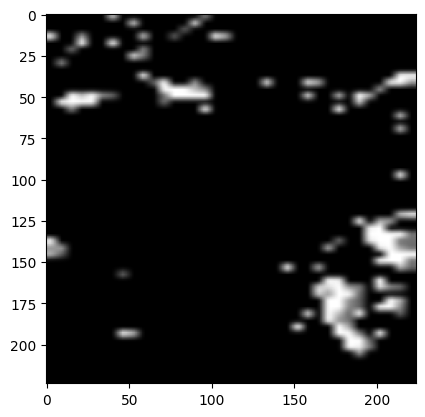

tensor([0., 1.], dtype=torch.float64)


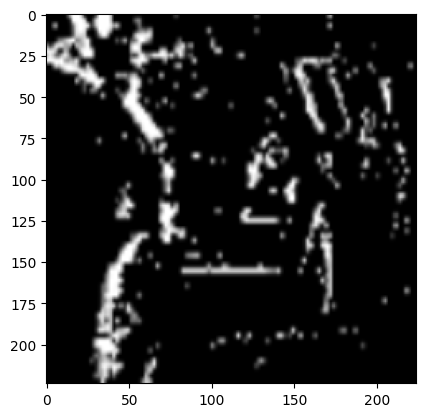

tensor([0., 1.], dtype=torch.float64)


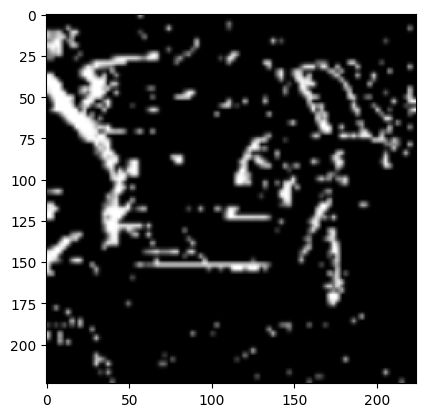

tensor([0., 1.], dtype=torch.float64)


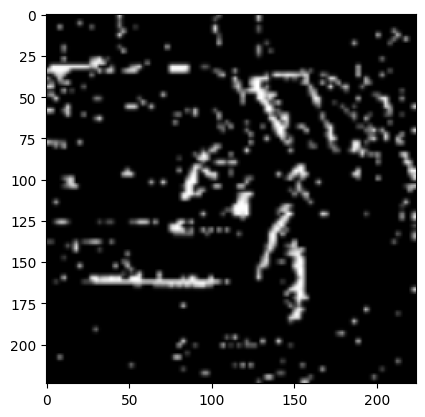

tensor([0., 1.], dtype=torch.float64)


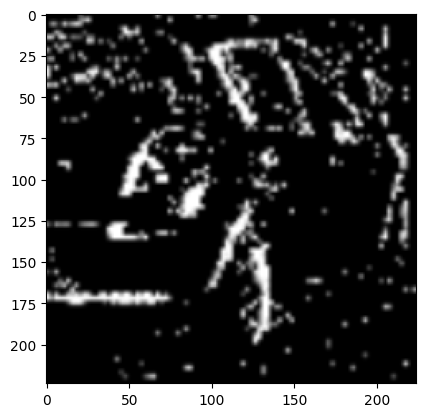

tensor([0., 1.], dtype=torch.float64)


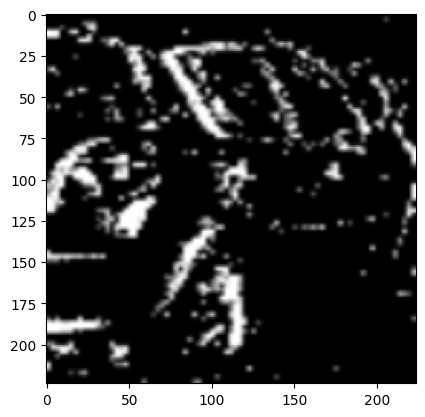

tensor([0., 1.], dtype=torch.float64)


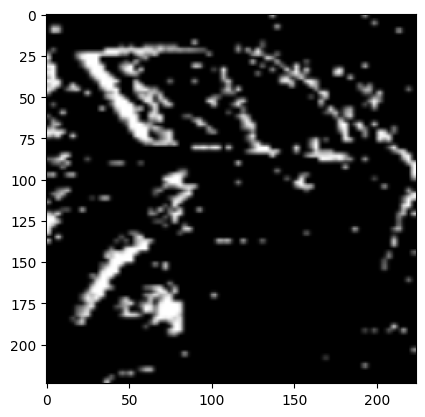

tensor([0., 1.], dtype=torch.float64)


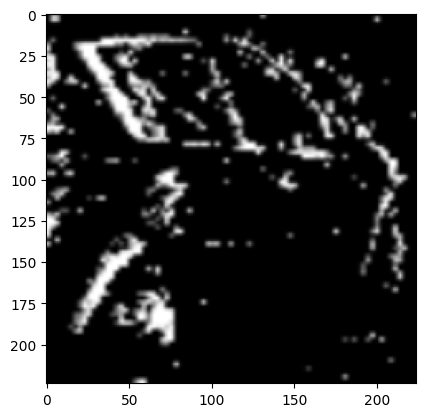

tensor([0., 1.], dtype=torch.float64)


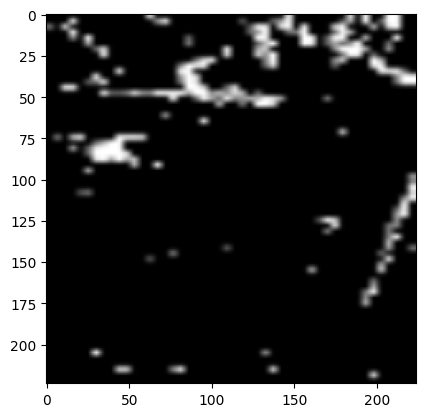

tensor([0., 1.], dtype=torch.float64)


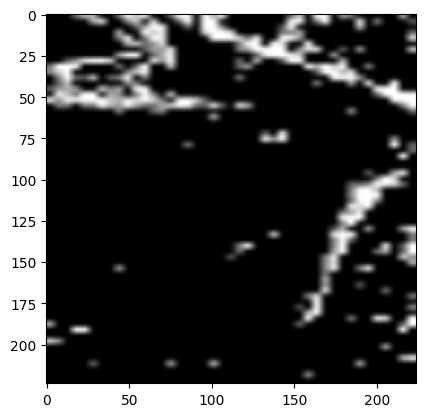

In [19]:
import matplotlib.pyplot as plt
for i in range(4000,4010):
    plt.imshow(train_dataloader.dataset[i][0][0,:,:])
    plt.gray()
    print(train_dataloader.dataset[i][1])
    plt.show()

In [20]:
import matplotlib.pyplot as plt
for i in range(4000,4010):
    plt.imshow(train_x[i])
    print(train_y[i])
    plt.show()

NameError: name 'train_x' is not defined